# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 06 : pipeline de modélisation et premières expérimentations
---

### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Dernière mise à jour :** 10/01/2026
* **Dépendances notebooks**: Notebooks 0 à 7,feature engineering

### Description
Ce notebook constitue la première étape de la construction des modèles prédictifs. Il s’appuie sur les données nettoyées et enrichies afin de tester plusieurs approches de modélisation, comparer leurs performances et établir une base de référence. L’objectif est de documenter un pipeline reproductible et d’identifier les modèles les plus prometteurs.


### Objectifs principaux
1. Charger le dataset préparé depuis `processed/`.  
2. Mettre en place le split train/test.  
3. Entraîner les modèles baseline :  
   - Régression linéaire.  
   - Régression Ridge/Lasso.  
   - Random Forest.  
4. Évaluer les performances avec RMSE, MAE, R².  
5. Intégrer MLflow pour tracer les runs (paramètres, métriques, artefacts).  
6. Documenter les résultats et générer un rapport synthétique.

---
### Dépendances critiques
* `src.feature_engineering` : pipeline de features.  
* `src.utils` : fonctions de split et métriques.  
* `sklearn` : librairie de modélisation.  
* `mlflow` : suivi des expériences.

### LIVRABLES
1. Modèles baseline entraînés et sauvegardés (`models/`).  
2. Résultats des métriques dans MLflow UI.  
3. Tableaux comparatifs des performances (`reports/model_baseline.md`).  
4. Visualisations des résidus et des distributions d’erreurs.  
5. Notebook documenté et reproductible via des scripts

---

# 📚 Table des matières

- [Section 0 : Importation des packages](#section-0)  
- [Section 1 : Chargement des données feature engineering](#section-1)  
- [Section 2 : Préprocessing et split train/test](#section-2)  
- [Section 3 : Entraînement des modèles basiques](#section-3)  
- [Section 4 : Évaluation des performances](#section-4)  
- [Section 5 : Intégration MLflow](#section-5)  
- [Section 6 : Documentation et synthèse](#section-6)  

> Note : la table des matières est indicative. Utilisez la navigation intégrée de votre éditeur (ex. outline VSCode) pour accéder rapidement aux sections.
---

<a id="section-0"></a>
# Section 0 : Importation des packages

In [21]:
import logging
import pandas as pd
from pathlib import Path
import logging
import numpy as np


# Import des fonctions utilitaires 

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

import seaborn as sns
import matplotlib.pyplot as plt

#pipeline data
from utils.config_loader import load_config
from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from feature_engineering.build_features import run_feature_engineering_pipeline
import copy

# pipeline modele
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score









In [22]:
# Configuration du logger pour voir les infos dans le notebook
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger("notebook")

<a id="section-1"></a>
# Section 1:Chargement des data

In [23]:
cfg = load_config()
create_directories(cfg)

cfg_ml = copy.deepcopy(cfg)
# désactiver l'imputation dans la copie ml (non persistée)
cfg_ml.cleaning.section_1.enable_imputation = False

# Chargement raw
logger.info("--- 1. LOADING ---")
df_raw = load_data_raw(cfg)



2026-01-11 21:49:44,880 - Configuration 'config' chargée (project_root=C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2)
2026-01-11 21:49:44,880 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\raw
2026-01-11 21:49:44,880 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim
2026-01-11 21:49:44,887 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed
2026-01-11 21:49:44,887 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\figures
2026-01-11 21:49:44,892 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\reports
2026-01-11 21:49:44,896 - --- 1. LOADING ---
2026-01-11 21:49:44,925 - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-11 21:49:44,945 - ✔️ 2016_Building_Energy_Benchmarking.csv : Identique à la version précédente.


In [24]:

# CLEANING sans imputation
logger.info(" CLEANING sans imputation")
df_cleaned = run_cleaning_pipeline(df_raw, cfg_ml)  #imputation False

2026-01-11 21:49:44,966 -  CLEANING sans imputation
2026-01-11 21:49:44,966 - --- Exécution : section_0 ---
2026-01-11 21:49:45,066 - --- Exécution : section_2 ---
2026-01-11 21:49:45,132 - --- Exécution : section_3 ---


   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_2 : -36 lignes exportées vers section_2_removed.csv


2026-01-11 21:49:45,515 - --- Exécution : section_1 ---
2026-01-11 21:49:45,631 - ✓ Données sauvegardées dans : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim\data_cleaned.csv


   [Audit] section_3 : -59 lignes exportées vers section_3_removed.csv
   [Audit] section_1 : -108 lignes exportées vers section_1_removed.csv


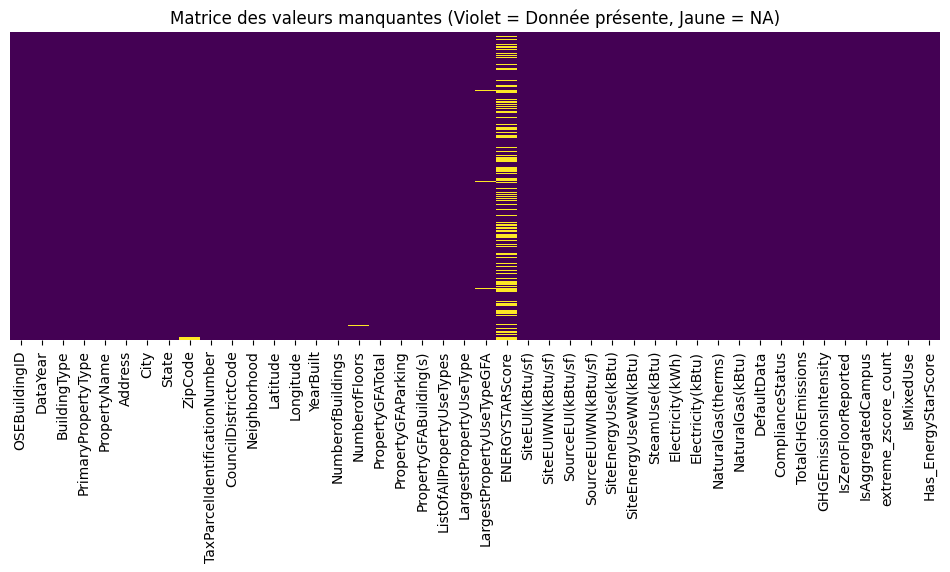

In [25]:
plt.figure(figsize=(12, 4))
sns.heatmap(df_cleaned.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Matrice des valeurs manquantes (Violet = Donnée présente, Jaune = NA)")
plt.show()

# Section 2 : Split train-test

In [26]:
df_cleaned["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'K-12 School', 'Large Office', 'Medical Office', 'Retail Store',
       'Hospital', 'Warehouse', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant'], dtype=object)

In [27]:
# Détection rapide des valeurs manquantes
TARGET = "TotalGHGEmissions"

print("NaN dans Target:", df_cleaned[TARGET].isna().sum())
print("Pourcentage:", df_cleaned[TARGET].isna().mean() * 100)

# NaN par type de bâtiment
print("\nNaN par PrimaryPropertyType:")
print(df_cleaned.groupby('PrimaryPropertyType')[TARGET].apply(lambda x: x.isna().sum()))

NaN dans Target: 0
Pourcentage: 0.0

NaN par PrimaryPropertyType:
PrimaryPropertyType
Distribution Center            0
Hospital                       0
Hotel                          0
K-12 School                    0
Laboratory                     0
Large Office                   0
Medical Office                 0
Mixed Use Property             0
Other                          0
Refrigerated Warehouse         0
Restaurant                     0
Retail Store                   0
Self-Storage Facility          0
Small- and Mid-Sized Office    0
Supermarket / Grocery Store    0
University                     0
Warehouse                      0
Worship Facility               0
Name: TotalGHGEmissions, dtype: int64


## Split avant feature engineering et log transformation de target

In [28]:
TARGET = "TotalGHGEmissions"
X = df_cleaned.drop(columns=[TARGET])
y = np.log1p(df_cleaned[TARGET])

# Le split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_cleaned['PrimaryPropertyType']
)


## Feature Engineering 

>Note :En soit le Double Feature Engineering est une erreur :si run_feature_engineering_pipeline calcule des moyennes ou des medianes sur le teste alors cela créer du leakage: le test est transformé avec ses propres statistiques au lieu de celles du train .Dans notre cas tel n'est pas le cas.Auncun probléme n'interviens et au vue du code cela revient au même que de regrouper les deux .Pour des contraintes de temps nous conservons notre demarche

In [29]:

# En cas d'éventuel calcul groupé lors du feature enginenning

logger.info(" Feature Engineering sur TRAIN ")
X_train.name = "X_train"
X_test.name = "X_test"
# Ces transformations doivent être conçues pour n'utiliser que les données de X_train en cas d'utilisation de stats globale
df_train_fe = run_feature_engineering_pipeline(X_train, cfg_ml)
y_train = y_train.loc[df_train_fe.index]  # Réaligner les cibles 

logger.info(" Feature Engineering sur TEST ")
# Appliquez les MÊMES transformations au test, sans ré-apprendre de paramètres.
df_test_fe = run_feature_engineering_pipeline(X_test, cfg_ml)
y_test = y_test.loc[df_test_fe.index]

#  Préparation  pour le pipeline ML
X_train_clean = df_train_fe.copy()
X_test_clean = df_test_fe.copy()


2026-01-11 21:49:46,121 -  Feature Engineering sur TRAIN 
2026-01-11 21:49:46,125 - --- Démarrage : Feature Engineering ---


✓ Feature engineering sauvegardé dans : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed\X_train.csv

2026-01-11 21:49:46,270 - ✓ Feature Engineering terminé. Shape: (1136, 20)
2026-01-11 21:49:46,270 -  Feature Engineering sur TEST 
2026-01-11 21:49:46,275 - --- Démarrage : Feature Engineering ---
2026-01-11 21:49:46,332 - ✓ Feature Engineering terminé. Shape: (285, 20)



✓ Feature engineering sauvegardé dans : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed\X_test.csv


In [30]:
X_train_clean.columns

Index(['NumberofFloors', 'NumberofBuildings', 'Age', 'ENERGYSTARScore',
       'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'Latitude',
       'Longitude', 'Is_Downtown', 'distance_to_center_proxy', 'log_GFA',
       'surface_per_building', 'surface_per_floor', 'Has_Parking',
       'Parking_share', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam',
       'Age_ENERGYSTAR'],
      dtype='object')

In [31]:
X_train_clean.shape

(1136, 20)

In [32]:
X_test.shape

(285, 43)

In [33]:
y_train.head()

1191    3.923556
1968    3.379974
980     4.879615
119     7.628916
2087    2.989211
Name: TotalGHGEmissions, dtype: float64

# Section 3 : Modéle baseline

In [34]:
print(X_train_clean.columns.tolist())

['NumberofFloors', 'NumberofBuildings', 'Age', 'ENERGYSTARScore', 'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'Latitude', 'Longitude', 'Is_Downtown', 'distance_to_center_proxy', 'log_GFA', 'surface_per_building', 'surface_per_floor', 'Has_Parking', 'Parking_share', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam', 'Age_ENERGYSTAR']


## Custom Transformers

In [35]:
# clé de regroupement
GROUP_COL = "PrimaryPropertyType"

if GROUP_COL not in X_train_clean.columns:
    raise ValueError(f"{GROUP_COL} absent de X_train_clean")
if X_train_clean[GROUP_COL].isna().any():
    raise ValueError(f"{GROUP_COL} contient des NaN dans X_train_clean")

# exclure GROUP_COL des listes finales
num_cols = X_train_clean.select_dtypes(include="number").columns.tolist()
cat_cols = X_train_clean.select_dtypes(include="object").columns.tolist()
if GROUP_COL in num_cols: num_cols.remove(GROUP_COL)
if GROUP_COL in cat_cols: cat_cols.remove(GROUP_COL)

# pour GroupModeImputer on peut laisser None pour inférer dans fit()
# mais ici on fixe explicitement les colonnes catégorielles (sans GROUP_COL)
categorical_features = cat_cols.copy()

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, min_group_size: int = 1):
        # stocker les paramètres exactement comme reçus
        self.group_col = group_col
        self.min_group_size = min_group_size

    def fit(self, X: pd.DataFrame, y=None):
        # X est attendu comme DataFrame contenant self.group_col + colonnes numériques ciblées
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        # compter et calculer médianes par groupe
        group_counts = X.groupby(self.group_col).size()
        medians = X.groupby(self.group_col).median(numeric_only=True)
        # fallback pour petits groupes (mettre NaN pour forcer repli global si minimum groupe non atteint)
        for g, cnt in group_counts.items():
            if cnt < self.min_group_size and g in medians.index:
                medians.loc[g, :] = np.nan
        self.group_medians_ = medians
        self.global_median_ = X.median(numeric_only=True)
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        # imputer chaque colonne numérique calculée au fit()
        for col in self.group_medians_.columns:
            if col not in X.columns:
                # si la colonne attendue n'est pas présente, skip (robustesse)
                continue
            X[col] = X[col].fillna(X[self.group_col].map(self.group_medians_[col]))
            X[col] = X[col].fillna(self.global_median_[col])
        # retirer la colonne de regroupement avant le scaler
        return X.drop(columns=[self.group_col], errors="ignore")


class GroupModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, categorical_cols=None, min_group_size: int = 1):
        # ne pas transformer categorical_cols ici 
        self.group_col = group_col
        self.categorical_cols = categorical_cols  # peut être None ; on infère dans fit()
        self.min_group_size = min_group_size

    def fit(self, X: pd.DataFrame, y=None):
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        # si categorical_cols None, inférer toutes les colonnes non-group de type object/category
        if self.categorical_cols is None:
            inferred = X.select_dtypes(include=["object", "category"]).columns.tolist()
            self.categorical_cols = [c for c in inferred if c != self.group_col]
        # calculer mode par groupe
        group_counts = X.groupby(self.group_col).size()
        self.group_modes_ = {}
        for col in self.categorical_cols:
            modes = X.groupby(self.group_col)[col].agg(
                lambda s: s.mode().iloc[0] if not s.mode().empty else None
            )
            for g, cnt in group_counts.items():
                if cnt < self.min_group_size and g in modes.index:
                    modes.loc[g] = None
            self.group_modes_[col] = modes
        # global modes fallback
        self.global_modes_ = {col: X[col].mode().iloc[0] for col in self.categorical_cols}
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.categorical_cols:
            if col not in X.columns:
                continue
            X[col] = X[col].fillna(X[self.group_col].map(self.group_modes_.get(col, pd.Series())))
            X[col] = X[col].fillna(self.global_modes_.get(col))
        # retirer la colonne de regroupement avant l'encodeur
        return X.drop(columns=[self.group_col], errors="ignore")



## Construction des Pipelines

In [36]:

# construire pipelines


numeric_pipeline = Pipeline([
    ("imputer", GroupMedianImputer(group_col=GROUP_COL, min_group_size=1)),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", GroupModeImputer(group_col=GROUP_COL, categorical_cols=categorical_features, min_group_size=1)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) # handle_unknown="ignore" pour Les nouvelles catégories rencontrées dans les données de test sont ignorées
    #  sparse_output=False pour facilier la conversion en dataframe de la matrice OneHotEncoder

# ColumnTransformer : on transmet [GROUP_COL] + cols à chaque sous-pipeline
# Applique numeric_pipeline sur [GROUP_COL] + num_cols (GROUP_COL passé pour imputation, puis supprimé)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, [GROUP_COL] + num_cols),
        ("cat", categorical_pipeline, [GROUP_COL] + cat_cols),
    ],
    remainder="drop"
)



In [ ]:

# pipeline run
model = RandomForestRegressor(n_estimators=200, random_state=72, n_jobs=-1)
ml_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", model)
])

# fit / predict
ml_pipeline.fit(X_train_clean, y_train)
y_pred = ml_pipeline.predict(X_test_clean)



In [39]:
print(X_train_clean.shape, X_test_clean.shape)
print(y_train.shape, y_test.shape)
print(np.intersect1d(X_train_clean.index, X_test_clean.index))


(1136, 20) (285, 20)
(1136,) (285,)
[]


In [40]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    max_error,
    median_absolute_error
)
import numpy as np

# Prédictions
y_pred = ml_pipeline.predict(X_test_clean)

# 1. Erreurs classiques
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
maxe = max_error(y_test, y_pred)

# 2. Scores de variance
r2 = r2_score(y_test, y_pred)
expl_var = explained_variance_score(y_test, y_pred)

# 3. Affichage synthétique
metrics = {
    "MAE": mae,
    "MSE": mse,
    "MedAE": medae,
    "Max Error": maxe,
    "R2": r2,
    "Explained Variance": expl_var
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


MAE: 0.6007
MSE: 0.5910
MedAE: 0.5023
Max Error: 2.5712
R2: 0.7149
Explained Variance: 0.7152


L'analyse de ces métriques révèle que notre modèle affiche une performance globale robuste, comme en témoigne un R^2 de 0,71 indiquant que nous expliquons près de 71 % de la variance des émissions de CO2. La précision de nos estimations est confirmée par une MAE de 0,6007 , bien que l'écart représenté par la Max Error de 2,5712 souligne la persistance de quelques prédictions atypiques difficiles à capturer.

---


## Analyse des résidus

In [41]:
residuals = y_test - y_pred

### Scatter plot des résidus vs prédictions

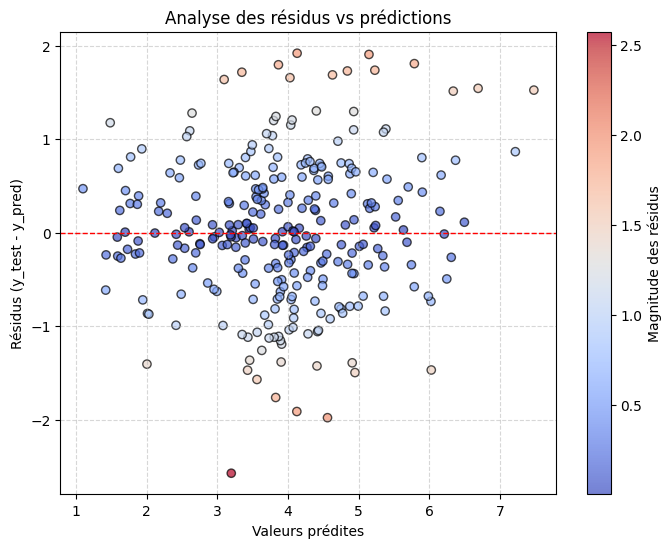

In [43]:
plt.figure(figsize=(8, 6))

# Colorer les points selon la valeur absolue du résidu
plt.scatter(y_pred, residuals, 
            c=np.abs(residuals), cmap="coolwarm", 
            alpha=0.7, edgecolor="k")

# Ligne horizontale à zéro
plt.axhline(0, color="red", linestyle="--", linewidth=1)

# Grille pour lisibilité
plt.grid(True, linestyle="--", alpha=0.5)

# Labels et titre
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus (y_test - y_pred)")
plt.title("Analyse des résidus vs prédictions")

# Barre de couleur pour magnitude des résidus
cbar = plt.colorbar()
cbar.set_label("Magnitude des résidus")

plt.show()

nous pouvons observer une forte concentration des points bleus le long de la ligne horizontale rouge, ce qui indique que notre modèle est particulièrement performant pour prédire les émissions de la majorité des bâtiments. La répartition équilibrée des résidus de part et d'autre de l'axe zéro démontre que notre pipeline ne présente pas de biais systématique majeur de sur-évaluation ou de sous-évaluation.

Par ailleurs, nous constatons plusieurs points d'amélioration identifiables visuellement :

* La gestion des valeurs extrêmes : Les points tendant vers le rouge et l'orangé mettent en évidence nos erreurs les plus significatives, notamment un cas de forte surestimation (point rouge en bas) et plusieurs sous-estimations pour des bâtiments à fortes émissions.
* **L'évolution de la variance** : On constate un léger élargissement du nuage de points à mesure que les valeurs prédites augmentent, ce qui indique une forme d'hétéroscédasticité ; notre modèle est naturellement plus précis sur les petites structures que sur les bâtiments industriels ou complexes.
* **L'impact des outliers** : La présence de résidus dépassant la valeur de 2 confirme que certains facteurs spécifiques à ces bâtiments (usages particuliers ou équipements énergivores non répertoriés) échappent encore à la logique de notre modéle.


### QQ-plot

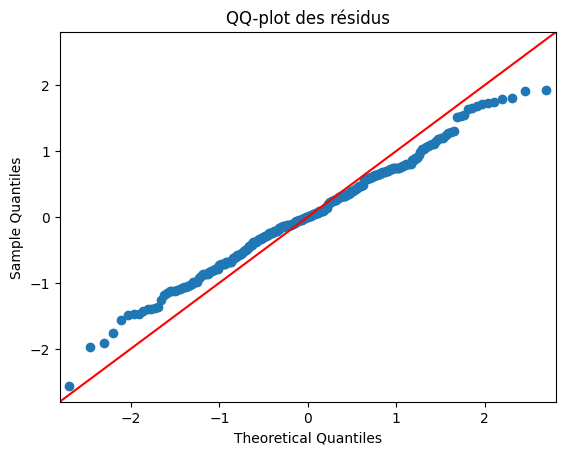

In [44]:
import statsmodels.api as sm
sm.qqplot(residuals, line="45")
plt.title("QQ-plot des résidus")
plt.show()


#### l'analyse du QQ-plot des résidus :

D'après ce graphique, nous constatons que les points suivent globalement la ligne rouge diagonale dans la partie centrale, ce qui indique que nos erreurs de prédiction suivent approximativement une distribution normale pour la majorité des observations. Cette caractéristique est positive car elle valide l'une des hypothèses fondamentales de nombreux modèles statistiques et confirme que notre modèle capte correctement la structure principale des données.

On constate toutefois une déviation aux deux extrémités de la distribution. En bas à gauche et en haut à droite, les points s'écartent de la ligne rouge, ce qui indique que notre distribution possède des "queues lourdes" (heavy tails). Cela signifie que les erreurs extrêmes sont plus fréquentes que ce que prévoirait une distribution normale parfaite.

On constate également une légère courbure en haut à droite du graphique, ce qui indique que notre modèle a tendance à sous-estimer les valeurs les plus élevées de la cible. Les points les plus éloignés de la ligne confirment la présence d'outliers significatifs, représentant des bâtiments dont le comportement énergétique est atypique par rapport au reste de l'échantillon.